In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from keras.layers import Input, Dense, Flatten, concatenate, Dropout, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical
import sklearn.utils.class_weight
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
import random
np.random.seed(42)
import xgboost as xgb
import seaborn as sns
sns.set()
plt.rcParams["figure.figsize"] = (15, 7)


In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# READING DATA

In [ ]:
classes = pd.read_table('/content/drive/My Drive/doan1/data/profile.txt', header=None)

In [ ]:
classes.columns = ['cooler', 'valve', 'pump', 'accumulator' , 'flag']


In [ ]:
cooler = pd.get_dummies(classes['cooler'])
valve = pd.get_dummies(classes['valve'])
pump = pd.get_dummies(classes['pump'])
accumulator = pd.get_dummies(classes['accumulator'])
flag = pd.get_dummies(classes['flag'])


In [ ]:

dir_path = '/content/drive/My Drive/doan1/data'
file_list = os.listdir(dir_path)


In [ ]:
file_list

['EPS1.txt',
 'FS1.txt',
 'FS2.txt',
 'CE.txt',
 'CP.txt',
 'PS1.txt',
 'PS2.txt',
 'PS3.txt',
 'PS4.txt',
 'PS5.txt',
 'PS6.txt',
 'SE.txt',
 'TS1.txt',
 'TS2.txt',
 'TS3.txt',
 'TS4.txt',
 'VS1.txt',
 'profile.txt',
 'documentation.txt',
 'description.txt']

In [ ]:
text_files = [file for file in file_list if file not in ['profile.txt','description.txt','documentation.txt']]


In [ ]:

text_files

['EPS1.txt',
 'FS1.txt',
 'FS2.txt',
 'CE.txt',
 'CP.txt',
 'PS1.txt',
 'PS2.txt',
 'PS3.txt',
 'PS4.txt',
 'PS5.txt',
 'PS6.txt',
 'SE.txt',
 'TS1.txt',
 'TS2.txt',
 'TS3.txt',
 'TS4.txt',
 'VS1.txt']

1D CNN

# DOWNSAMPLING TECHNIQUE 

In [ ]:
TS1 = pd.read_table('/content/drive/My Drive/doan1/data/PS1.txt', header=None)

In [ ]:
TS1

,0,1,2,3,4,5,6,7,8,9,...,5990,5991,5992,5993,5994,5995,5996,5997,5998,5999
0,151.47,151.45,151.52,151.27,150.80,150.69,153.89,154.67,152.88,153.82,...,151.16,151.19,151.25,151.16,151.10,151.16,151.14,151.10,151.21,151.19
1,151.11,151.12,151.16,150.92,150.70,150.62,152.40,153.21,152.81,153.53,...,150.82,150.82,150.86,150.80,150.73,150.79,150.84,150.79,150.80,150.86
2,150.81,150.79,150.84,150.65,150.35,150.23,152.03,152.81,152.44,153.27,...,150.49,150.44,150.47,150.46,150.38,150.47,150.50,150.43,150.54,150.62
3,150.48,150.47,150.52,150.31,150.04,149.98,151.63,152.48,152.24,152.94,...,150.34,150.30,150.28,150.38,150.41,150.33,150.31,150.31,150.25,150.28
4,150.41,150.35,150.24,150.12,149.87,149.71,151.64,152.37,151.78,152.68,...,150.31,150.20,150.17,150.28,150.31,150.25,150.27,150.22,150.13,150.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2200,151.70,151.83,151.90,151.75,151.62,151.63,153.78,154.73,153.83,154.43,...,151.84,151.75,151.67,151.76,151.81,151.78,151.78,151.83,151.84,151.86
2201,151.90,151.83,151.81,151.77,151.65,151.63,153.97,154.84,153.67,154.37,...,151.81,151.81,151.84,151.83,151.79,151.87,151.87,151.75,151.77,151.78
2202,151.73,151.78,151.84,151.62,151.46,151.49,153.91,154.88,153.69,154.24,...,151.73,151.66,151.73,151.71,151.68,151.79,151.84,151.73,151.73,151.83
2203,151.77,151.77,151.75,151.56,151.47,151.57,154.09,154.80,153.45,154.21,...,151.75,151.71,151.68,151.71,151.73,151.75,151.71,151.68,151.71,151.78


In [ ]:

#This code implement upsampling time series data with goals up to 100hz sampling rate
def upsampling_row(row):
    target_num_points = 600
    num_points = len(row)

    resampled_row = np.interp(np.linspace(0, num_points-1, target_num_points), np.arange(num_points), row)
    return pd.Series(resampled_row)

def downsampling_row(df):
    grouped = df.groupby(np.arange(df.shape[1]) // 10, axis=1).mean()

    return grouped


In [ ]:

PS1 = pd.read_table('/content/drive/My Drive/doan1/data/PS1.txt', header=None)
grouped = TS1.groupby(np.arange(TS1.shape[1]) // 10, axis=1).mean()


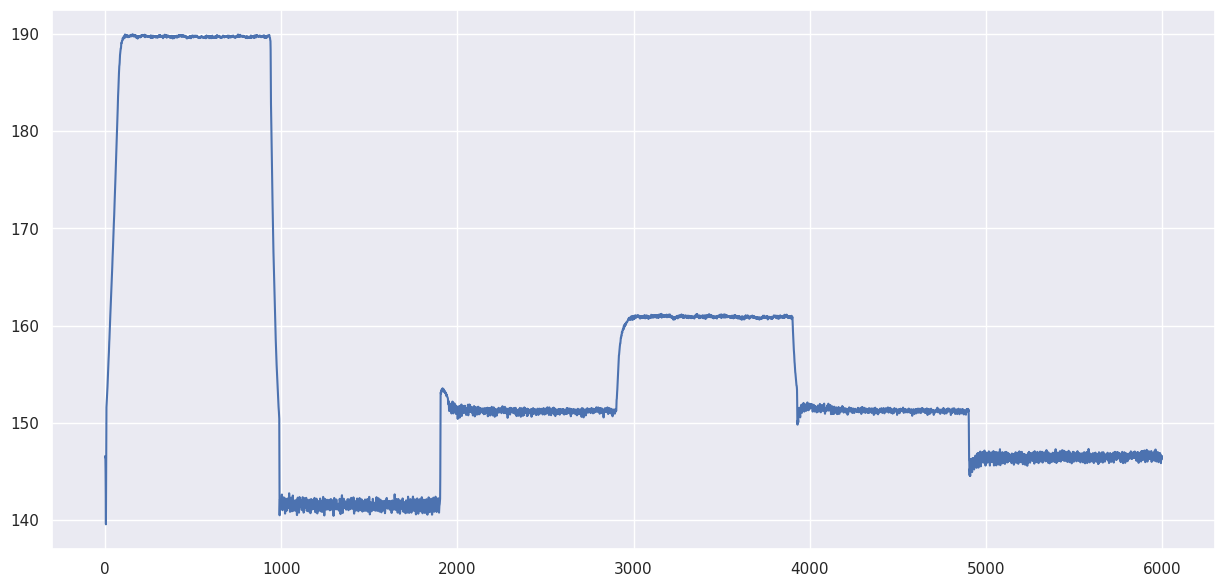

In [ ]:
plt.plot(TS1.iloc[250].T);


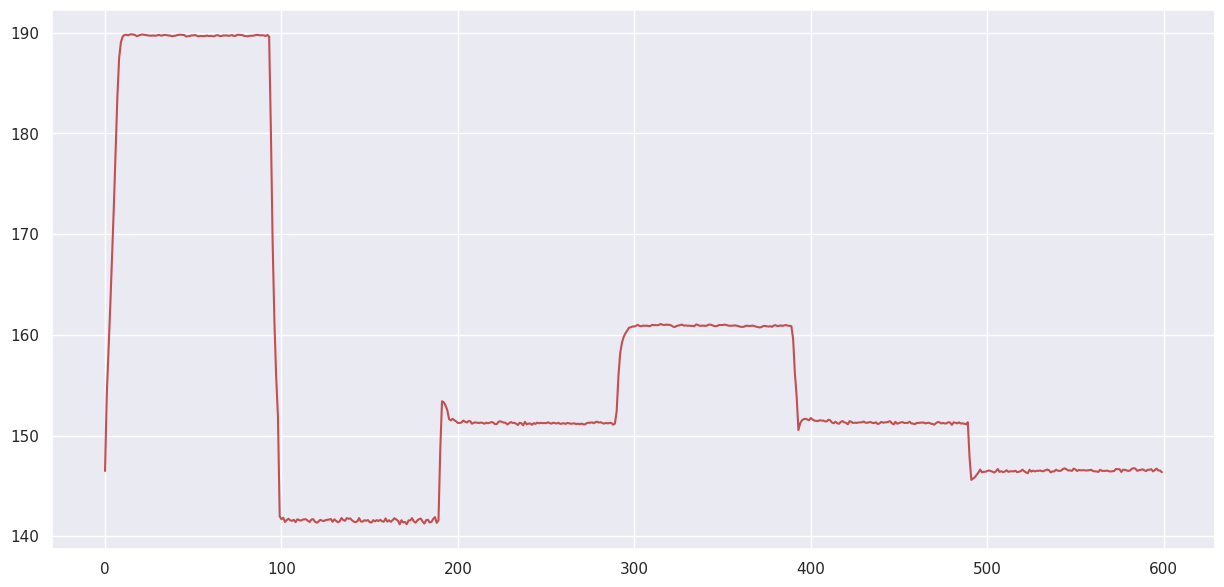

In [ ]:
plt.plot(grouped.iloc[250].T,'r');

In [ ]:
def data_processing_resampling():
    dfs = {}
    up_list = ['TS1','TS2','TS3','TS4','VS1','CE','CP','SE']
    down_list = ['PS1','PS2','PS3','PS4','PS5','PS6','EPS1']
    for file in text_files:
        file_path = os.path.join(dir_path, file)
        df = pd.read_table(file_path,header=None)
        feature = file.rstrip('.txt')
        if feature in up_list:
            df = df.apply(upsampling_row, axis=1)
        if feature in down_list:
            df = downsampling_row(df)
        dfs[feature] = df
    return dfs
  

In [ ]:

trainning_data_dict = data_processing_resampling()


In [ ]:
def data_processing_handle_missing(trainning_data_dict):
    for df in trainning_data_dict:
      null_counts = trainning_data_dict[df].isna().sum()
      check_feature_null = null_counts[null_counts > 1].index.tolist()
      check_feature_null
      trainning_data_dict[df][check_feature_null] = trainning_data_dict[df][check_feature_null].fillna(0)
      scaler = StandardScaler()
      trainning_data_dict[df] = scaler.fit_transform(trainning_data_dict[df])
      return trainning_data_dict

In [ ]:
trainning_data_dict = data_processing_handle_missing(trainning_data_dict)

# MULTI-HEAD-CHANNEL-1D CONV


In [ ]:
data_1 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['VS1','EPS1']])
data_2 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['PS1','PS2','TS1','FS1','PS3','TS2']])
data_3 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['PS4','PS5','TS3','PS6','TS4','FS2']])
data_4 = np.dstack([trainning_data_dict[df] for df in trainning_data_dict if df in ['CE','CP','SE']])
#each channel represent an sensor, data in shape (time_step, channel)

In [ ]:
from keras.layers import Input, Dense, Flatten, concatenate
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras import backend as K

# Define input shapes
input1_shape = (600, 2) #all sensors placed near pump and accumulator
input2_shape = (600, 6) #all sensors placed arround valve
input3_shape = (600, 6) #all sensors arround cooler 
input4_shape = (600, 3) #all virtual sensors


# Define input layers
input1 = Input(shape=input1_shape)
input2 = Input(shape=input2_shape)
input3 = Input(shape=input3_shape)
input4 = Input(shape=input4_shape)

# First convolutional layer for input1
conv1_1 = Conv1D(filters=32, kernel_size=100,strides=2,activation='relu')(input1)
pool1_1 = MaxPooling1D(pool_size=2)(conv1_1)
conv1_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool1_1)
pool1_2 = MaxPooling1D(pool_size=2)(conv1_2)
flat1 = Flatten()(pool1_2)

# Second convolutional layer for input2
conv2_1 = Conv1D(filters=32, kernel_size=100,strides=2, activation='relu')(input2)
pool2_1 = MaxPooling1D(pool_size=2)(conv2_1)
conv2_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool2_1)
pool2_2 = MaxPooling1D(pool_size=2)(conv2_2)
flat2 = Flatten()(pool2_2)
# Second convolutional layer for input3
conv3_1 = Conv1D(filters=32, kernel_size=100,strides=2, activation='relu')(input3)
pool3_1 = MaxPooling1D(pool_size=2)(conv3_1)
conv3_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool3_1)
pool3_2 = MaxPooling1D(pool_size=2)(conv3_2)
flat3 = Flatten()(pool3_2)
# Second convolutional layer for input4
conv4_1 = Conv1D(filters=32, kernel_size=100,strides=2, activation='relu')(input4)
pool4_1 = MaxPooling1D(pool_size=2)(conv4_1)
conv4_2 = Conv1D(filters=64, kernel_size=30,strides=2, activation='relu')(pool4_1)
pool4_2 = MaxPooling1D(pool_size=2)(conv4_2)
flat4 = Flatten()(pool4_2)
# Merge input channels
merged = concatenate([flat1, flat2,flat3,flat4])

# Define output layers
dense1 = Dense(512, activation='relu')(merged)
dense2 = Dense(64, activation='relu')(dense1)

output_1 = Dense(4, activation='softmax')(dense2)
output_2 = Dense(3, activation='softmax')(dense2)
output_3 = Dense(4, activation='softmax')(dense2)
output_4 = Dense(3, activation='softmax')(dense2)
output_5 = Dense(2, activation='softmax')(dense2)

# Define the model
model_1 = Model(inputs=[input1, input2, input3, input4], outputs=output_1) #accumulator 
model_2 = Model(inputs=[input1, input2, input3, input4], outputs=output_2)#pump
model_3 = Model(inputs=[input1, input2, input3, input4], outputs=output_3)#valve
model_4 = Model(inputs=[input1, input2, input3, input4], outputs=output_4)#cooler
model_5 = Model(inputs=[input1, input2, input3, input4], outputs=output_5)#flag

# Compile the model

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
def f1_macro(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_macro = K.mean(2*((precision*recall)/(precision+recall+K.epsilon())))
    return f1_macro
filepath_1 = '/content/drive/My Drive/doan1/weights_cnn_/accumulators.hdf5'
filepath_2 = '/content/drive/My Drive/doan1/weights_cnn_/pump.hdf5'
filepath_3 = '/content/drive/My Drive/doan1/weights_cnn_/valve.hdf5'
filepath_4 = '/content/drive/My Drive/doan1/weights_cnn_/cooler.hdf5'
filepath_5 = '/content/drive/My Drive/doan1/weights_cnn_/flag.hdf5'
checkpoint_1 = ModelCheckpoint(filepath_1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_2 = ModelCheckpoint(filepath_2, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_3 = ModelCheckpoint(filepath_3, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_4 = ModelCheckpoint(filepath_4, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_5 = ModelCheckpoint(filepath_5, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_3.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_4.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])
model_5.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy',f1_macro])


# Train the model


ACCUMULATOR 

In [ ]:
X_train1_accumulator, X_val1_accumulator, y_train1_accumulator, y_val1_accumulator = train_test_split(data_1, accumulator, test_size=0.2, random_state=42, stratify=accumulator)
X_train2_accumulator, X_val2_accumulator, y_train2_accumulator,  y_val2_accumulator = train_test_split(data_2, accumulator, test_size=0.2, random_state=42, stratify=accumulator)
X_train3_accumulator, X_val3_accumulator, y_train3_accumulator,  y_val3_accumulator = train_test_split(data_3, accumulator, test_size=0.2, random_state=42, stratify=accumulator)
X_train4_accumulator, X_val4_accumulator, y_train4_accumulator , y_val4_accumulator = train_test_split(data_4, accumulator, test_size=0.2, random_state=42, stratify=accumulator)

In [ ]:
model_1.summary()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 600, 2)]     0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 600, 6)]     0           []                               
                                                                                                  
 input_11 (InputLayer)          [(None, 600, 6)]     0           []                               
                                                                                                  
 input_12 (InputLayer)          [(None, 600, 3)]     0           []                               
                                                                                           

In [ ]:
history = model_1.fit([X_train1_accumulator, X_train2_accumulator,  X_train3_accumulator, X_train4_accumulator], y_train1_accumulator, epochs=20, callbacks=[checkpoint_1],batch_size=32,validation_data=([X_val1_accumulator, X_val2_accumulator, X_val3_accumulator, X_val4_accumulator], y_val1_accumulator))


Epoch 1/20
54/56 [===========================>..] - ETA: 0s - loss: 0.2029 - accuracy: 0.9144 - f1_macro: 0.8917
Epoch 1: val_loss did not improve from 0.22989
56/56 [==============================] - 1s 13ms/step - loss: 0.2041 - accuracy: 0.9150 - f1_macro: 0.8841 - val_loss: 0.2586 - val_accuracy: 0.9025 - val_f1_macro: 0.8724
Epoch 2/20
55/56 [============================>.] - ETA: 0s - loss: 0.1759 - accuracy: 0.9295 - f1_macro: 0.9054
Epoch 2: val_loss did not improve from 0.22989
56/56 [==============================] - 1s 12ms/step - loss: 0.1755 - accuracy: 0.9297 - f1_macro: 0.9026 - val_loss: 0.2586 - val_accuracy: 0.9025 - val_f1_macro: 0.8592
Epoch 3/20
54/56 [===========================>..] - ETA: 0s - loss: 0.1779 - accuracy: 0.9242 - f1_macro: 0.9012
Epoch 3: val_loss did not improve from 0.22989
56/56 [==============================] - 1s 13ms/step - loss: 0.1759 - accuracy: 0.9252 - f1_macro: 0.8941 - val_loss: 0.2661 - val_accuracy: 0.9093 - val_f1_macro: 0.8810
Epoc

In [ ]:
#y_pred = model_1.predict([X_val1, X_val2, X_val3, X_val4])


In [ ]:
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)


PUMP

In [ ]:
X_train1_pump, X_val1_pump, y_train1_pump, y_val1_pump = train_test_split(data_1, pump, test_size=0.2, random_state=42, stratify=pump)
X_train2_pump, X_val2_pump, y_train2_pump,  y_val2_pump = train_test_split(data_2, pump, test_size=0.2, random_state=42, stratify=pump)
X_train3_pump, X_val3_pump, y_train3_pump,  y_val3_pump = train_test_split(data_3, pump, test_size=0.2, random_state=42, stratify=pump)
X_train4_pump, X_val4_pump, y_train4_pump,  y_val4_pump = train_test_split(data_4, pump, test_size=0.2, random_state=42, stratify=pump)

In [ ]:
history_2 = model_2.fit([X_train1_pump, X_train2_pump,  X_train3_pump, X_train4_pump], y_train1_pump, epochs=50, batch_size=32,callbacks=[checkpoint_2],validation_data=([X_val1_pump, X_val2_pump, X_val3_pump, X_val4_pump], y_val1_pump))


Epoch 1/50
53/56 [===========================>..] - ETA: 0s - loss: 0.7872 - accuracy: 0.7506 - f1_macro: 0.6492
Epoch 1: val_loss did not improve from 0.11415
56/56 [==============================] - 1s 18ms/step - loss: 0.7687 - accuracy: 0.7551 - f1_macro: 0.6549 - val_loss: 0.3504 - val_accuracy: 0.8821 - val_f1_macro: 0.8323
Epoch 2/50
53/56 [===========================>..] - ETA: 0s - loss: 0.2571 - accuracy: 0.9074 - f1_macro: 0.8747
Epoch 2: val_loss did not improve from 0.11415
56/56 [==============================] - 1s 16ms/step - loss: 0.2622 - accuracy: 0.9048 - f1_macro: 0.8693 - val_loss: 0.3546 - val_accuracy: 0.8957 - val_f1_macro: 0.8586
Epoch 3/50
53/56 [===========================>..] - ETA: 0s - loss: 0.2281 - accuracy: 0.9151 - f1_macro: 0.8881
Epoch 3: val_loss did not improve from 0.11415
56/56 [==============================] - 1s 11ms/step - loss: 0.2297 - accuracy: 0.9144 - f1_macro: 0.8841 - val_loss: 0.2961 - val_accuracy: 0.9048 - val_f1_macro: 0.8695
Epoc

In [ ]:
# y_pred = model_2.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)
  

VALVE

In [ ]:
X_train1_valve, X_val1_valve, y_train1_valve, y_val1_valve = train_test_split(data_1, valve, test_size=0.2, random_state=42, stratify=valve)
X_train2_valve, X_val2_valve, y_train2_valve,  y_val2_valve = train_test_split(data_2, valve, test_size=0.2, random_state=42, stratify=valve)
X_train3_valve, X_val3_valve, y_train3_valve,  y_val3_valve = train_test_split(data_3, valve, test_size=0.2, random_state=42, stratify=valve)
X_train4_valve, X_val4_valve, y_train4_valve,  y_val4_valve = train_test_split(data_4, valve, test_size=0.2, random_state=42, stratify=valve)

In [ ]:
history_3 = model_3.fit([X_train1_valve, X_train2_valve,  X_train3_valve, X_train4_valve], y_train1_valve, epochs=10,callbacks=[checkpoint_3], batch_size=32,validation_data=([X_val1_valve, X_val2_valve, X_val3_valve, X_val4_valve], y_val1_valve))


Epoch 1/10
55/56 [============================>.] - ETA: 0s - loss: 0.5434 - accuracy: 0.8466 - f1_macro: 0.7647
Epoch 1: val_loss did not improve from 0.03129
56/56 [==============================] - 1s 18ms/step - loss: 0.5422 - accuracy: 0.8469 - f1_macro: 0.7689 - val_loss: 0.2654 - val_accuracy: 0.9161 - val_f1_macro: 0.8921
Epoch 2/10
55/56 [============================>.] - ETA: 0s - loss: 0.2013 - accuracy: 0.9273 - f1_macro: 0.8946
Epoch 2: val_loss did not improve from 0.03129
56/56 [==============================] - 1s 17ms/step - loss: 0.2009 - accuracy: 0.9274 - f1_macro: 0.8875 - val_loss: 0.2151 - val_accuracy: 0.9252 - val_f1_macro: 0.8926
Epoch 3/10
50/56 [=========================>....] - ETA: 0s - loss: 0.0815 - accuracy: 0.9762 - f1_macro: 0.9720
Epoch 3: val_loss did not improve from 0.03129
56/56 [==============================] - 1s 11ms/step - loss: 0.0782 - accuracy: 0.9773 - f1_macro: 0.9647 - val_loss: 0.0776 - val_accuracy: 0.9751 - val_f1_macro: 0.9624
Epoc

In [ ]:
# y_pred = model_3.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)

COOLER

In [ ]:
X_train1_cooler, X_val1_cooler, y_train1_cooler, y_val1_cooler = train_test_split(data_1, cooler, test_size=0.2, random_state=42, stratify=cooler)
X_train2_cooler, X_val2_cooler, y_train2_cooler,  y_val2_cooler = train_test_split(data_2, cooler, test_size=0.2, random_state=42, stratify=cooler)
X_train3_cooler, X_val3_cooler, y_train3_cooler,  y_val3_cooler = train_test_split(data_3, cooler, test_size=0.2, random_state=42, stratify=cooler)
X_train4_cooler, X_val4_cooler, y_train4_cooler,  y_val4_cooler = train_test_split(data_4, cooler, test_size=0.2, random_state=42, stratify=cooler)

In [ ]:
history_4 = model_4.fit([X_train1_cooler, X_train2_cooler,  X_train3_cooler, X_train4_cooler], y_train1_cooler, epochs=30, batch_size=32,callbacks=[checkpoint_4],validation_data=([X_val1_cooler, X_val2_cooler, X_val3_cooler, X_val4_cooler], y_val1_cooler))


Epoch 1/30
52/56 [==========================>...] - ETA: 0s - loss: 1.2862 - accuracy: 0.8504 - f1_macro: 0.8314
Epoch 1: val_loss improved from inf to 0.17336, saving model to /content/drive/My Drive/doan1/weights_cnn_/cooler.hdf5
56/56 [==============================] - 6s 25ms/step - loss: 1.2197 - accuracy: 0.8583 - f1_macro: 0.8369 - val_loss: 0.1734 - val_accuracy: 0.9751 - val_f1_macro: 0.9716
Epoch 2/30
49/56 [=========================>....] - ETA: 0s - loss: 0.0756 - accuracy: 0.9802 - f1_macro: 0.9790
Epoch 2: val_loss improved from 0.17336 to 0.07336, saving model to /content/drive/My Drive/doan1/weights_cnn_/cooler.hdf5
56/56 [==============================] - 1s 14ms/step - loss: 0.0776 - accuracy: 0.9785 - f1_macro: 0.9699 - val_loss: 0.0734 - val_accuracy: 0.9751 - val_f1_macro: 0.9737
Epoch 3/30
49/56 [=========================>....] - ETA: 0s - loss: 0.0619 - accuracy: 0.9809 - f1_macro: 0.9787
Epoch 3: val_loss improved from 0.07336 to 0.06574, saving model to /conten

In [ ]:
# y_pred = model_4.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)

FLAG

In [ ]:
X_train1_flag, X_val1_flag, y_train1_flag, y_val1_flag = train_test_split(data_1, flag, test_size=0.2, random_state=42, stratify=flag)
X_train2_flag, X_val2_flag, y_train2_flag,  y_val2_flag = train_test_split(data_2, flag, test_size=0.2, random_state=42, stratify=flag)
X_train3_flag, X_val3_flag, y_train3_flag,  y_val3_flag = train_test_split(data_3, flag, test_size=0.2, random_state=42, stratify=flag)
X_train4_flag, X_val4_flag, y_train4_flag,  y_val4_flag = train_test_split(data_4, flag, test_size=0.2, random_state=42, stratify=flag)

In [ ]:
history_5 = model_5.fit([X_train1_flag, X_train2_flag,  X_train3_flag, X_train4_flag], y_train1_flag, epochs=30, callbacks=[checkpoint_5],batch_size=32,validation_data=([X_val1_flag, X_val2_flag, X_val3_flag, X_val4_flag], y_val1_flag))


Epoch 1/30
56/56 [==============================] - ETA: 0s - loss: 0.4542 - accuracy: 0.8639 - f1_macro: 0.8390
Epoch 1: val_loss did not improve from 0.15799
56/56 [==============================] - 1s 19ms/step - loss: 0.4542 - accuracy: 0.8639 - f1_macro: 0.8390 - val_loss: 0.2418 - val_accuracy: 0.9025 - val_f1_macro: 0.8861
Epoch 2/30
56/56 [==============================] - ETA: 0s - loss: 0.2085 - accuracy: 0.9178 - f1_macro: 0.9057
Epoch 2: val_loss did not improve from 0.15799
56/56 [==============================] - 1s 18ms/step - loss: 0.2085 - accuracy: 0.9178 - f1_macro: 0.9057 - val_loss: 0.2141 - val_accuracy: 0.9116 - val_f1_macro: 0.8930
Epoch 3/30
56/56 [==============================] - ETA: 0s - loss: 0.1815 - accuracy: 0.9303 - f1_macro: 0.9119
Epoch 3: val_loss did not improve from 0.15799
56/56 [==============================] - 1s 18ms/step - loss: 0.1815 - accuracy: 0.9303 - f1_macro: 0.9119 - val_loss: 0.2044 - val_accuracy: 0.9138 - val_f1_macro: 0.9008
Epoc

In [ ]:

# y_pred = model_5.predict([X_val1, X_val2, X_val3, X_val4])
# y_pred = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_val1.values, axis=1)
# draw_confusion(y_true, y_pred)

SUMMARY

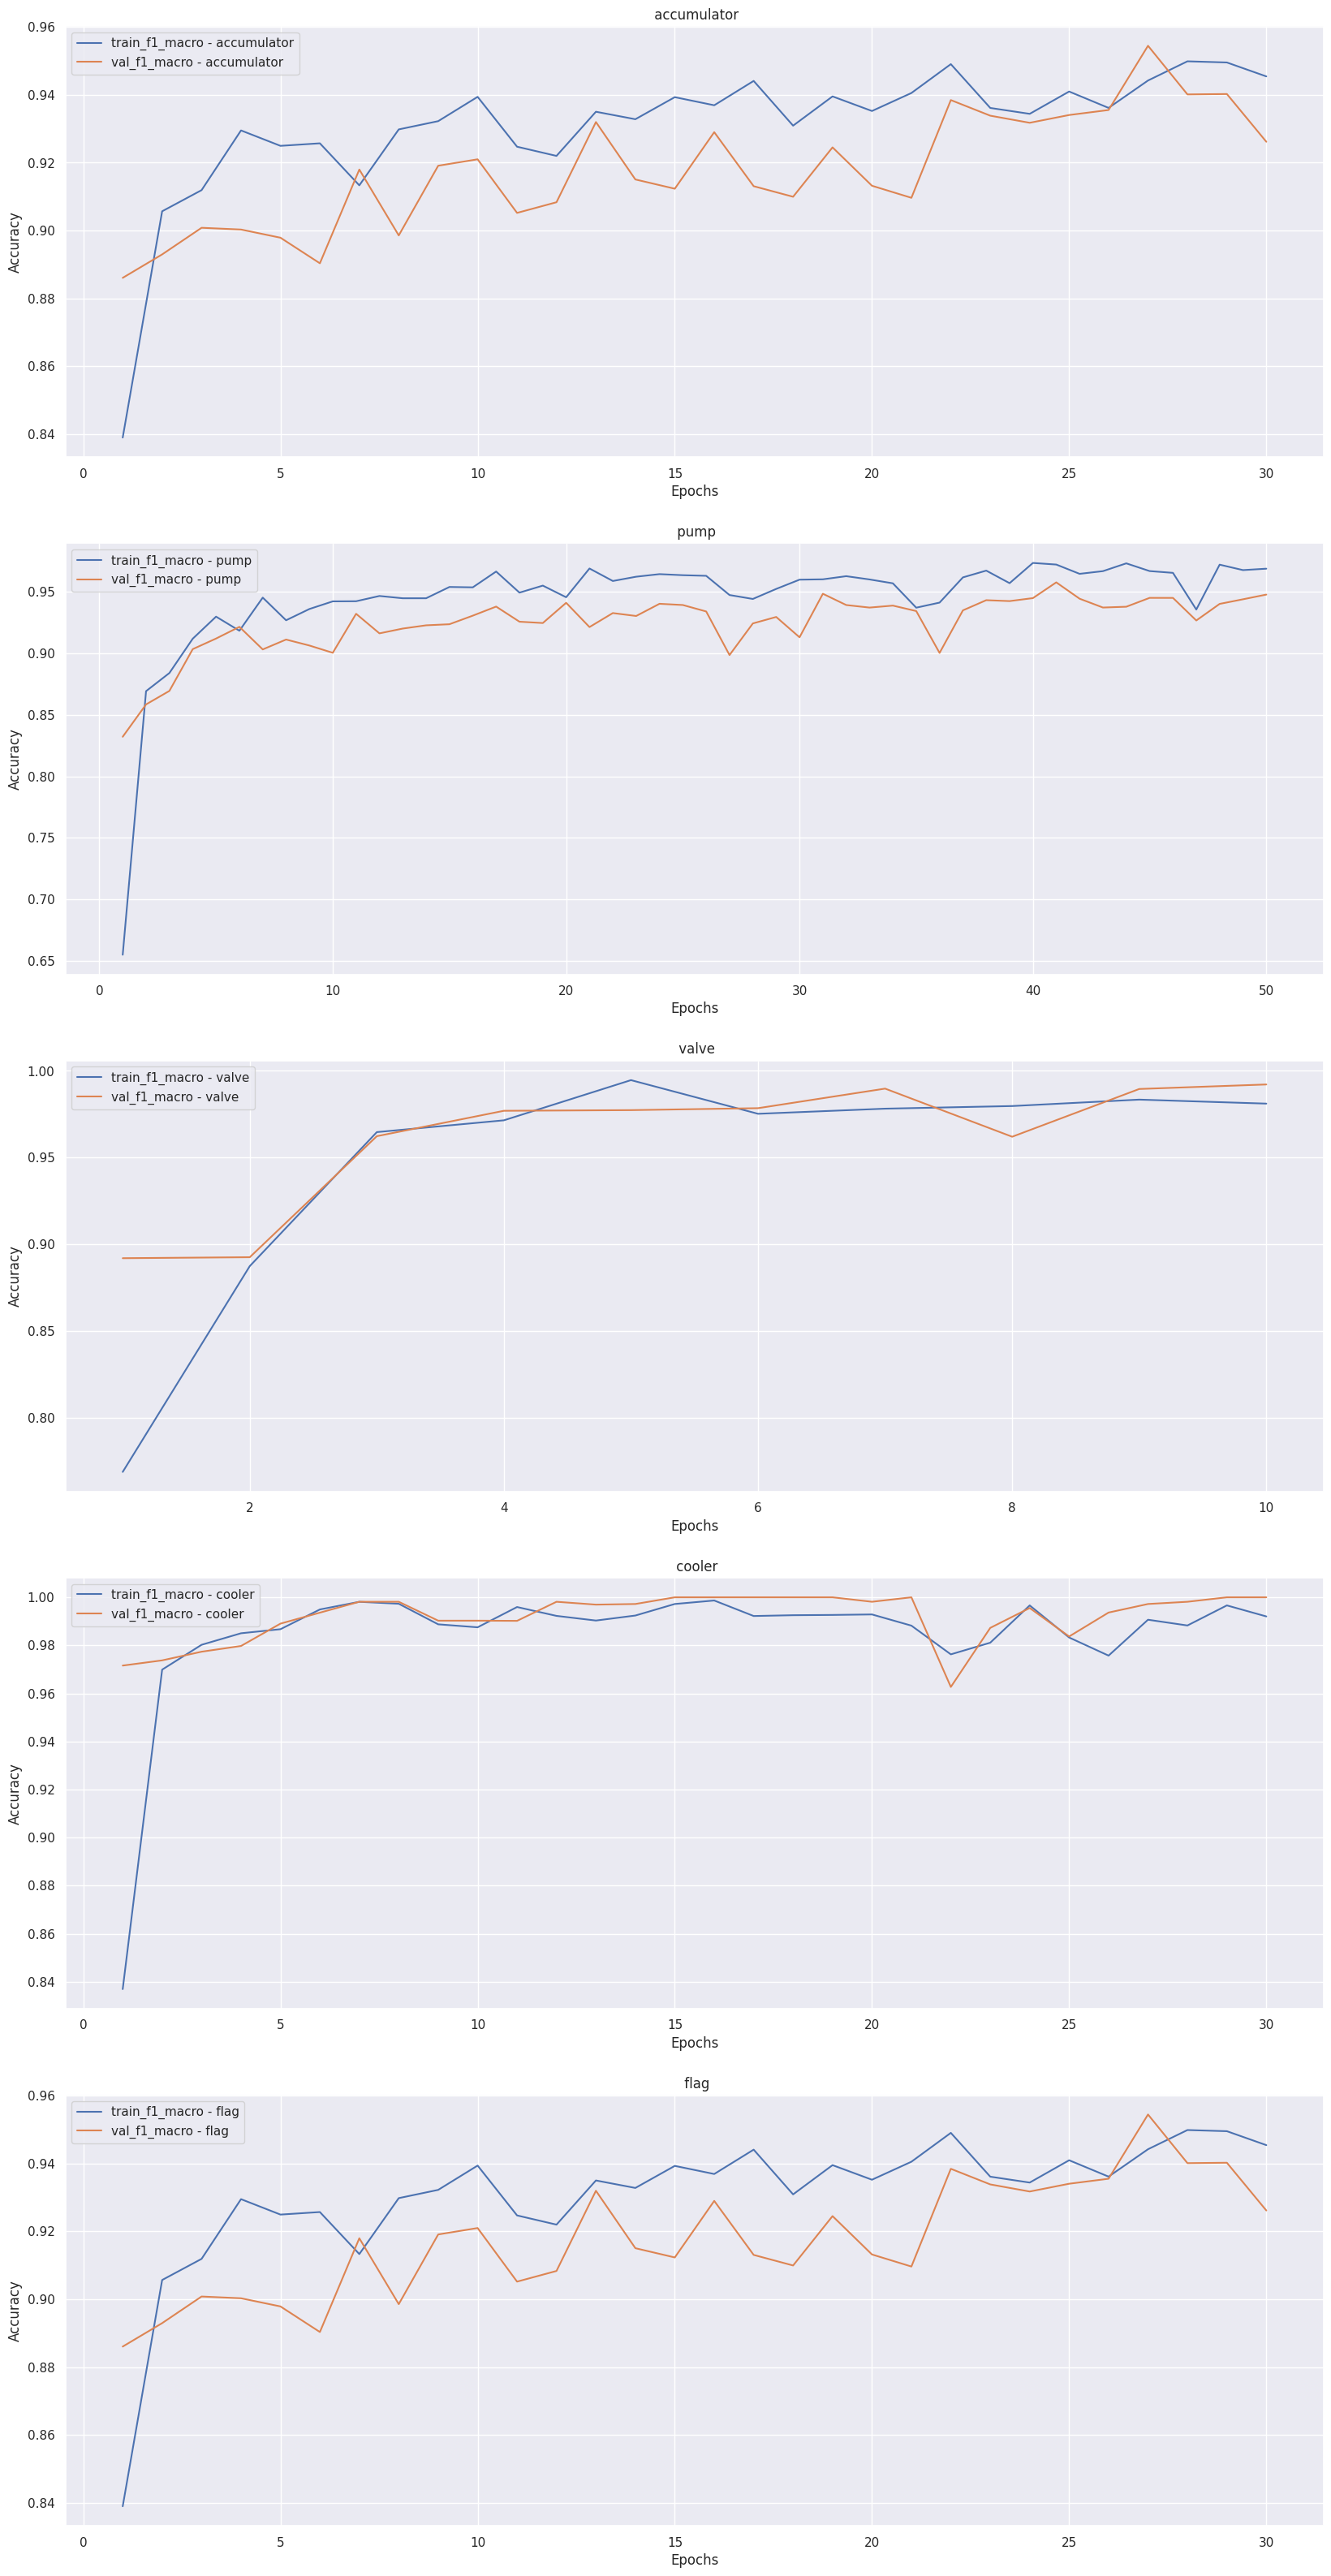

In [86]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 1, figsize=(20, 40))

for i, history in enumerate([history, history_2, history_3, history_4, history_5]):
    epochs = range(1, len(history.history['f1_macro']) + 1)
    train_acc = history.history['f1_macro']
    val_acc = history.history['val_f1_macro']
    axs[i].plot(epochs, train_acc, label=f'train_f1_macro - {["accumulator", "pump", "valve", "cooler", "flag"][i]}')
    axs[i].plot(epochs, val_acc, label=f'val_f1_macro - {["accumulator", "pump", "valve", "cooler", "flag"][i]}')
    axs[i].set_title(f' {["accumulator", "pump", "valve", "cooler", "flag"][i]}')
    axs[i].set_ylabel('Accuracy')
    axs[i].legend()
    axs[i].set_xlabel('Epochs')

plt.show()


In [ ]:
# Load the trained weights for each model
model_1.load_weights('/content/drive/My Drive/doan1/weights_cnn_/accumulators.hdf5')
output_1 = model_1.predict([X_val1_accumulator, X_val2_accumulator, X_val3_accumulator, X_val4_accumulator])
model_2.load_weights('/content/drive/My Drive/doan1/weights_cnn_/pump.hdf5')
output_2 = model_2.predict([X_val1_pump, X_val2_pump, X_val3_pump, X_val4_pump])
model_3.load_weights('/content/drive/My Drive/doan1/weights_cnn_/valve.hdf5')
output_3 = model_3.predict([X_val1_valve, X_val2_valve, X_val3_valve, X_val4_valve])
model_4.load_weights('/content/drive/My Drive/doan1/weights_cnn_/cooler.hdf5')
output_4 = model_4.predict([X_val1_cooler, X_val2_cooler, X_val3_cooler, X_val4_cooler])
model_5.load_weights('/content/drive/My Drive/doan1/weights_cnn_/flag.hdf5')
output_5 = model_5.predict([X_val1_flag, X_val2_flag, X_val3_flag, X_val4_flag])


14/14 [==============================] - 1s 5ms/step


In [ ]:
y_pred = [output_1,output_2,output_3,output_4,output_5]

In [ ]:
y_true = [y_val1_accumulator, y_val1_pump,y_val1_valve,y_val1_cooler,y_val1_flag]

In [ ]:
def draw_confusion(y_true, y_pred, labels, label, color):
    predict = np.argmax(y_pred, axis=1)
    true = np.argmax(y_true.values, axis=1)
    cm = confusion_matrix(true, predict)
    # Plot confusion matrix
    sns.set(font_scale=1)
    sns.heatmap(cm, annot=True, fmt='d', cmap=color, xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(label)
    plt.show()


DOWN-SAMPLING TECHNIQUE

In [ ]:
accumulator_labels = ['close to total failure', 'severely reduced pressure','slightly reduced pressure','optimal pressure']
pump_labels = ['no leakage', 'weak leakage', 'severe leakage']
valve_labels = ['close to total failure','severe lag', 'small lag', 'optimal switching behavior']
cooler_labels = ['close to total failure', 'reduced effifiency', 'full efficiency']
flag_labels = ['stable condition', 'unstable condition']
predict_labels = [accumulator_labels, pump_labels, valve_labels, cooler_labels,flag_labels]
labels = ['accumulator', 'pump', 'valve', 'cooler','flag']
colors = ['Blues', 'Greens', 'Reds', 'PuRd', 'YlOrBr']


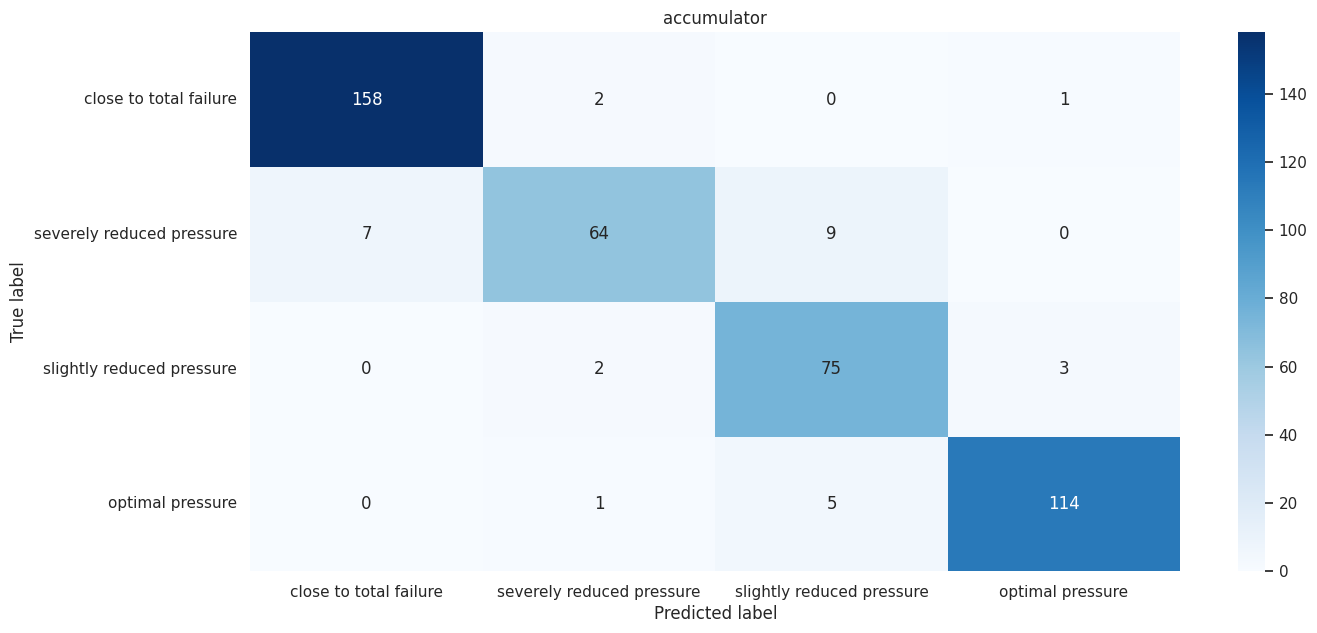

In [ ]:
draw_confusion(y_true[0],y_pred[0],predict_labels[0],labels[0], colors[0])


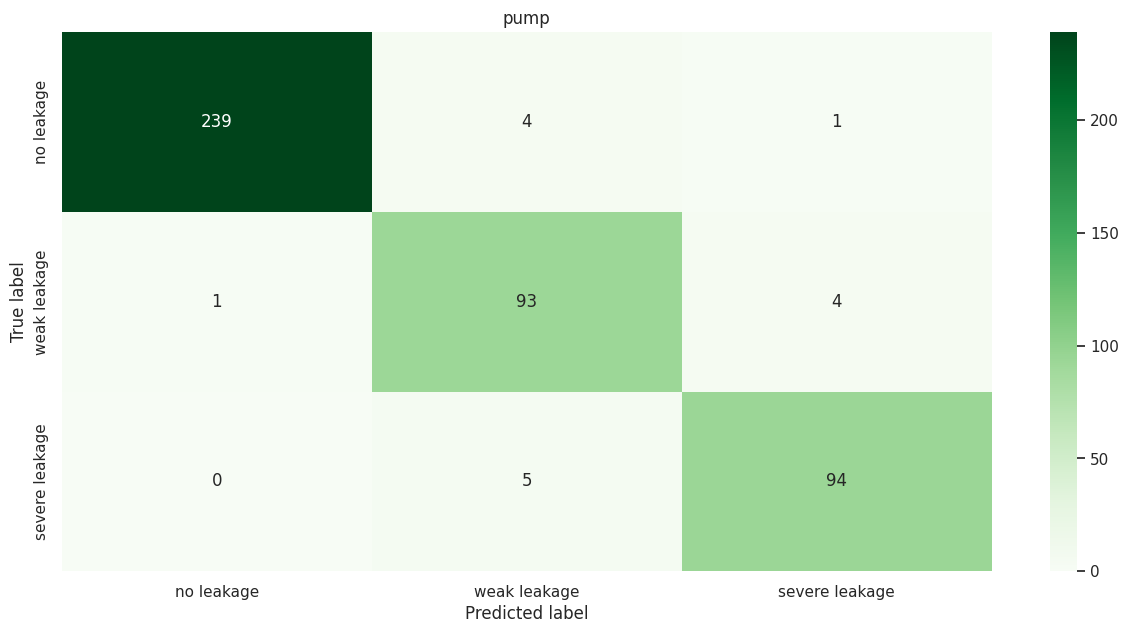

In [ ]:
draw_confusion(y_true[1],y_pred[1],predict_labels[1],labels[1], colors[1])


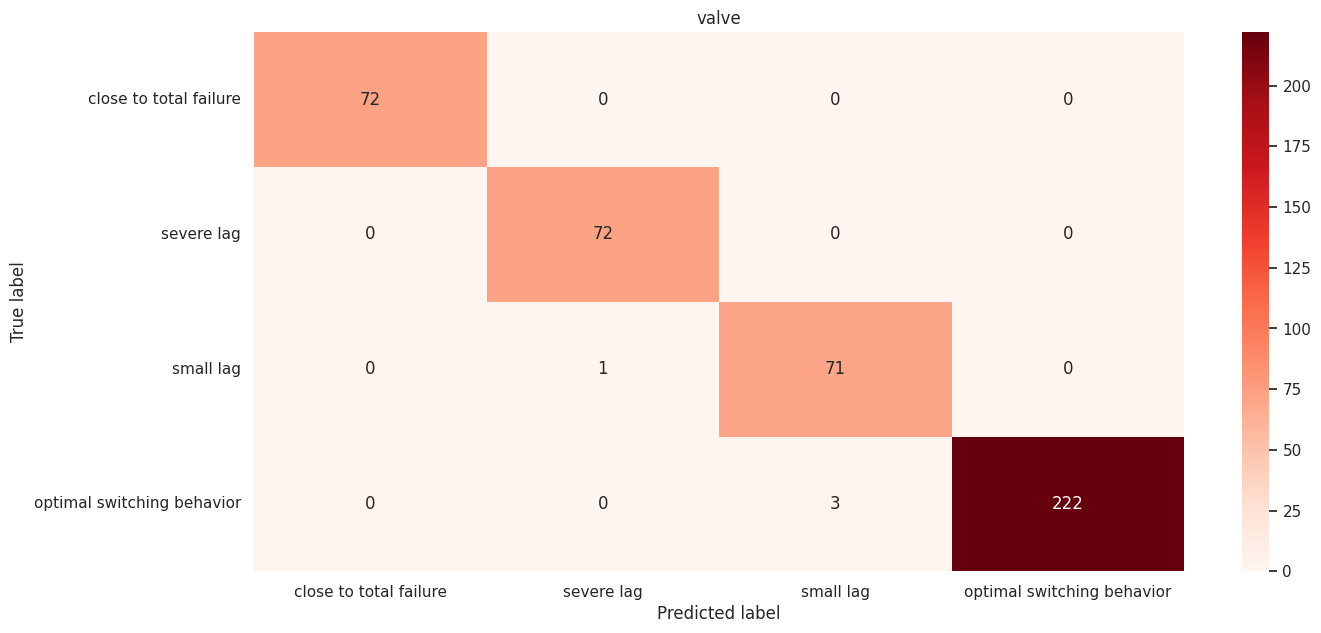

In [ ]:
draw_confusion(y_true[2],y_pred[2],predict_labels[2],labels[2], colors[2])


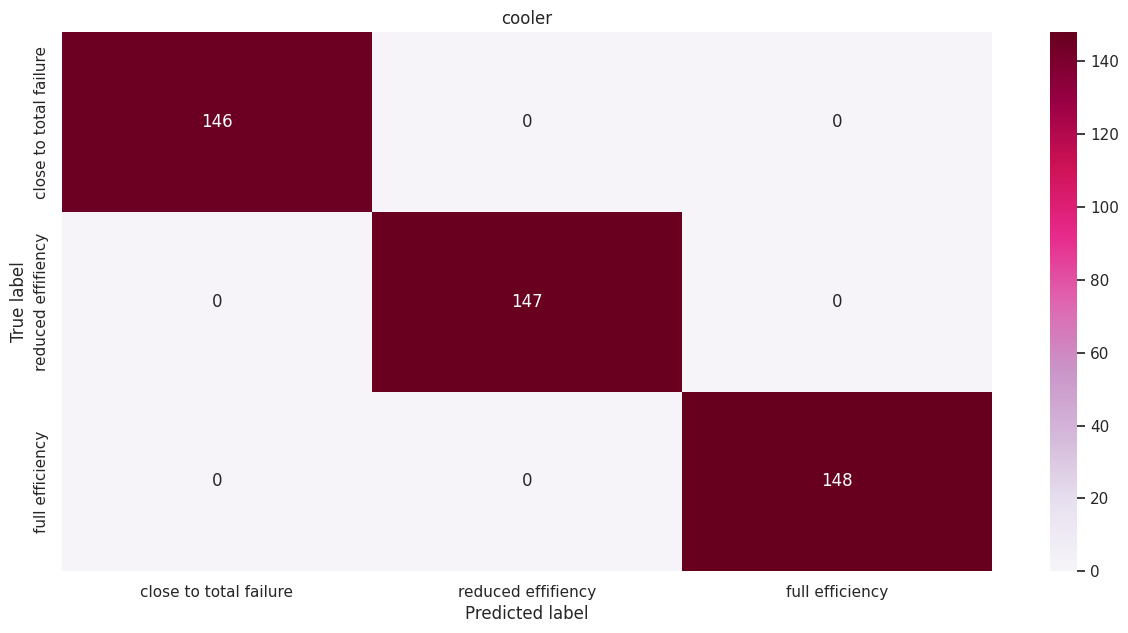

In [ ]:
draw_confusion(y_true[3],y_pred[3],predict_labels[3],labels[3], colors[3])


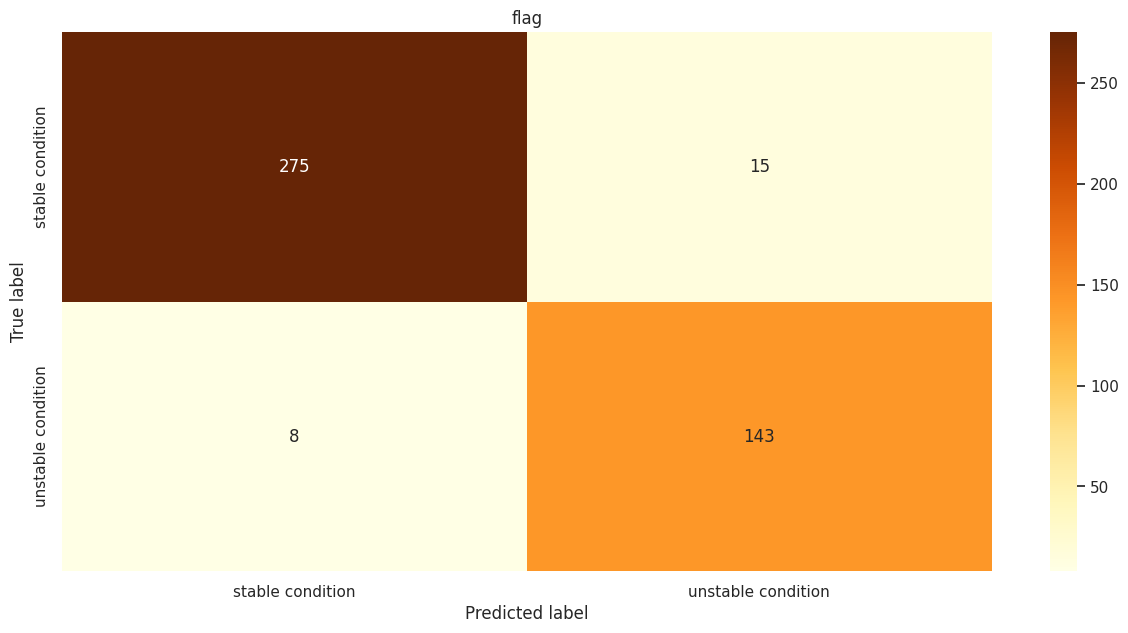

In [ ]:
draw_confusion(y_true[4],y_pred[4],predict_labels[4],labels[4], colors[4])
